In [1]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/x9/gt3hm8v90sqg1lhhj3y63ndw0000gn/T/pip-req-build-rl813wva
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/x9/gt3hm8v90sqg1lhhj3y63ndw0000gn/T/pip-req-build-rl813wva
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=c50efcb502c208f2ae21c1ec58306b55ef6de3a33d62cc9b6abb36453baac1ba
  Stored in directory: /private/var/folders/x9/gt3hm8v90sqg1lhhj3y63ndw0000gn/T/pip-ephem-wheel-cache-v6312um8/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [4]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-01-24 19:40:47--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.25, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  5.61MB/s    in 8m 34s  

2024-01-24 19:49:21 (4.76 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [23]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import cv2

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

(1024, 768, 3)


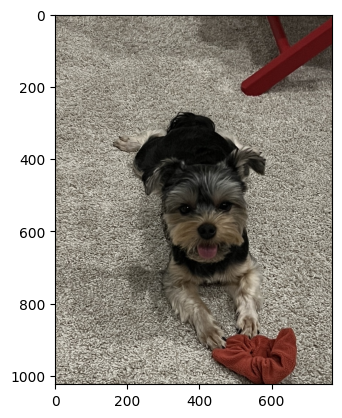

In [17]:
image = cv2.imread('ellie.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
print(image.shape)

In [18]:
sam_checkpoint = '/Users/chris/Documents_local/emoji_converter/segment/sam_vit_h_4b8939.pth'
model_type = 'vit_h'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [20]:
mask_generator = SamAutomaticMaskGenerator(
    model = sam,
    points_per_side = 32,
    pred_iou_thresh= 0.86,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100
)

In [21]:
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

28
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


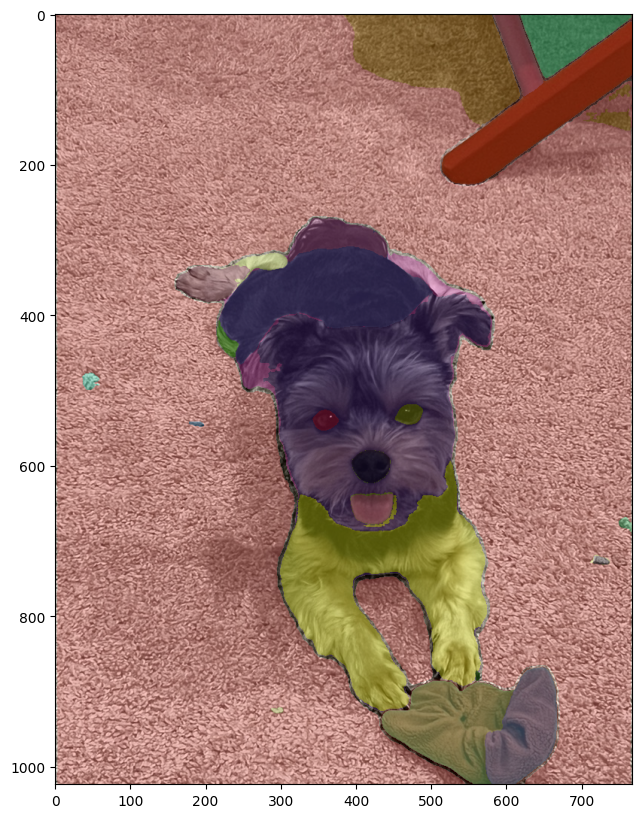

In [24]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse = True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)

In [26]:
from ultralytics import YOLO
import math
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:01<00:00, 3.76MB/s]


In [27]:
classnames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light",
              "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
              "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
              "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
              "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa",
              "potted plant", "bed", "dining table", "toilet", "tv monitor", "laptop", "mouse", "remote", "keyboard",
              "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"]

In [28]:
image.shape

(1024, 768, 3)


0: 640x480 1 dog, 1 skateboard, 68.6ms
Speed: 4.1ms preprocess, 68.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)
x1,y1 coordinate: (179, 272)
x2,y2 coordinate: (585, 936)
Width: 406
Height:664
Confidence of box : 0.86
 ------------------------------
x1,y1 coordinate: (511, 0)
x2,y2 coordinate: (767, 228)
Width: 256
Height:228
Confidence of box : 0.31
 ------------------------------


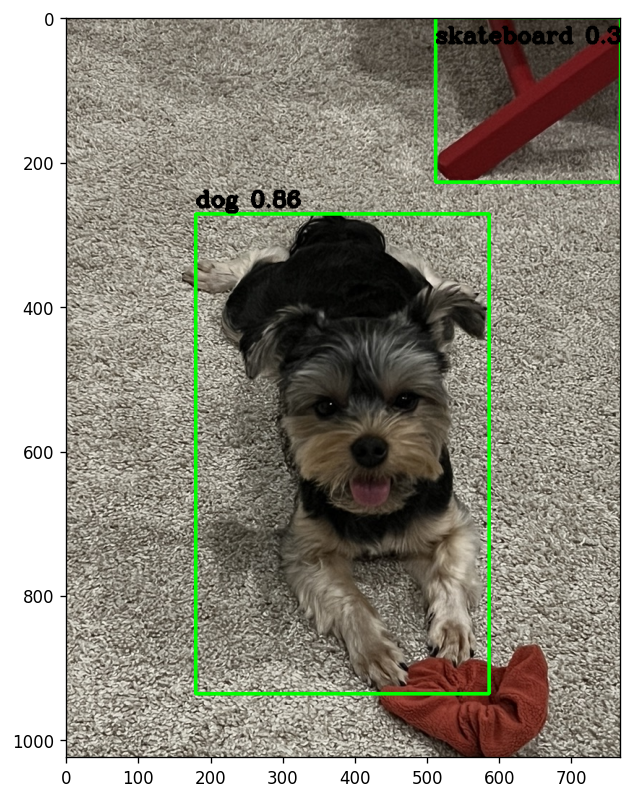

In [29]:
def show_bbox_and_label():
    results = model(image)
    
    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w, h = x2 - x1, y2 - y1
            print(f"x1,y1 coordinate: {(x1,y1)}\nx2,y2 coordinate: {x2,y2}\nWidth: {w}\nHeight:{h}")

            conf = math.ceil(box.conf[0] * 100) / 100
            print(f'Confidence of box : {conf}\n', "-"*30)
            
            cls = int(box.cls[0])
            cv2.rectangle(image, (x1,y1), (x2,y2), (0,255,0), 3)
            
            FONT = cv2.FONT_HERSHEY_COMPLEX
            COLOR = (0,0,0)
            THICKNESS = 3
            ORG = (max(0, x1), max(35, y1 - 10))
            cv2.putText(image, str(f"{classnames[cls]} {conf}"), ORG, FONT, 1, COLOR, THICKNESS)
        
    plt.figure(figsize= (15, 8), dpi= 120)
    plt.imshow(image)

show_bbox_and_label()

# ------------------------------------------------

In [30]:
results = model.predict('ellie.jpeg', conf = 0.25)


image 1/1 /Users/chris/Documents_local/emoji_converter/segment/ellie.jpeg: 640x480 1 dog, 1 baseball bat, 94.4ms
Speed: 5.3ms preprocess, 94.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


In [31]:
for result in results:
    boxes = result.boxes
bbox = boxes.xyxy.tolist()[0]

In [32]:
print(bbox)

[157.42807006835938, 269.65106201171875, 587.1053466796875, 959.5480346679688]


In [33]:
predictor = SamPredictor(sam)
predictor.set_image(image)

In [34]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [37]:
input_box = np.array(bbox)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

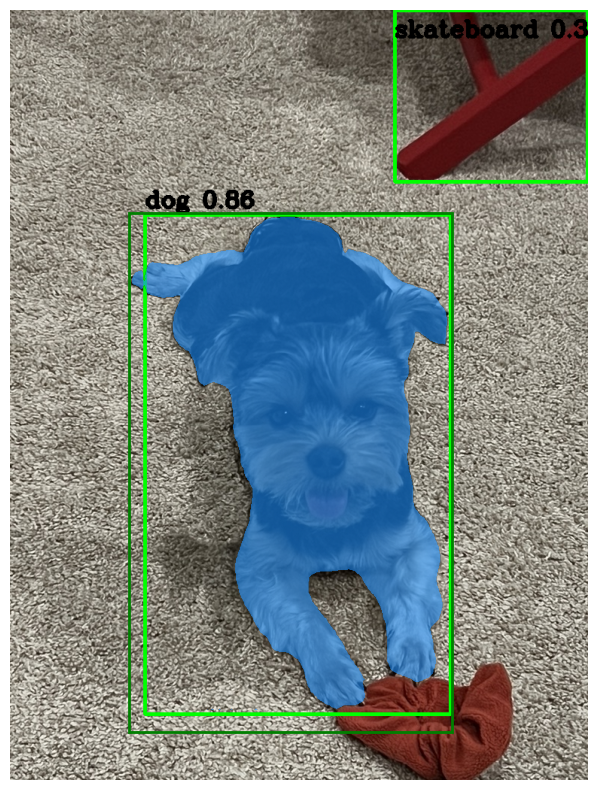

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

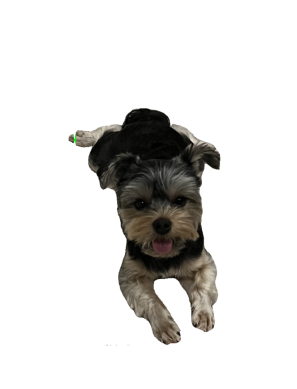

In [39]:
segmentation_mask = masks[0]

# Convert the segmentation mask to a binary mask
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)
white_background = np.ones_like(image) * 255

# Apply the binary mask
new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()